In [201]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [202]:
def load_imdb_data(directory):
    reviews = []
    sentiments = []
    for sentiment_label in ['pos', 'neg']:
        folder_path = os.path.join(directory, sentiment_label)
        for filename in os.listdir(folder_path):
            if filename.endswith(".txt"):
                full_path = os.path.join(folder_path, filename)
                with open(full_path, 'r', encoding='utf-8') as file:
                    text = file.read()
                reviews.append(text)
                sentiments.append(1 if sentiment_label == 'pos' else 0)
    return pd.DataFrame({'review': reviews, 'sentiment': sentiments})

In [203]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

In [204]:
def extract_features(train_corpus, test_corpus, max_features=1000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train = vectorizer.fit_transform(train_corpus).toarray()
    X_test = vectorizer.transform(test_corpus).toarray()
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
    
    return X_train, X_test, vectorizer

In [205]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    epsilon = 1e-5
    cost = -1/m * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
    return cost

def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = []
    for i in range(iterations):
        h = sigmoid(np.dot(X, theta))
        theta -= (alpha/m) * np.dot(X.T, (h - y))
        cost_history.append(compute_cost(X, y, theta))
    return theta, cost_history

def predict(X, theta, threshold=0.5):
    return (sigmoid(np.dot(X, theta)) >= threshold).astype(int)

In [206]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-score:  {f1:.3f}")

def plot_top_features(theta, vectorizer, top_n=10):
    coefficients = theta[1:] 
    feature_names = vectorizer.get_feature_names_out()
    top_pos_idx = np.argsort(coefficients)[-top_n:]
    top_neg_idx = np.argsort(coefficients)[:top_n]
    plt.figure(figsize=(10, 5))
    plt.barh(feature_names[top_pos_idx], coefficients[top_pos_idx], color='green', label='Positive')
    plt.barh(feature_names[top_neg_idx], coefficients[top_neg_idx], color='red', label='Negative')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} Positive and Negative Features")
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    mask = ~np.isnan(y_true)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]    
    cm = confusion_matrix(y_true_filtered, y_pred_filtered)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [207]:
def main():
    print("Loading IMDB data from folder structure...")
    train_df = load_imdb_data('train')
    test_df = load_imdb_data('test')
    
    train_df['clean_review'] = train_df['review'].apply(clean_text)
    test_df['clean_review'] = test_df['review'].apply(clean_text)
    
    print("Extracting TF-IDF features...")
    X_train, X_test, vectorizer = extract_features(train_df['clean_review'], test_df['clean_review'])
    y_train = train_df['sentiment'].values
    y_test = test_df['sentiment'].values
    
    print("Training Logistic Regression from scratch...")
    theta = np.zeros(X_train.shape[1])
    alpha = 0.1
    iterations = 1000
    theta, cost_history = gradient_descent(X_train, y_train, theta, alpha, iterations)
    
    print("Evaluating on test set...")
    y_pred = predict(X_test, theta)
    evaluate_model(y_test, y_pred)
    
    plot_top_features(theta, vectorizer, top_n=10)
    plot_confusion_matrix(y_test, y_pred)

Loading IMDB data from folder structure...
Extracting TF-IDF features...
Training Logistic Regression from scratch...
Evaluating on test set...
Accuracy:  0.769
Precision: 0.765
Recall:    0.777
F1-score:  0.771


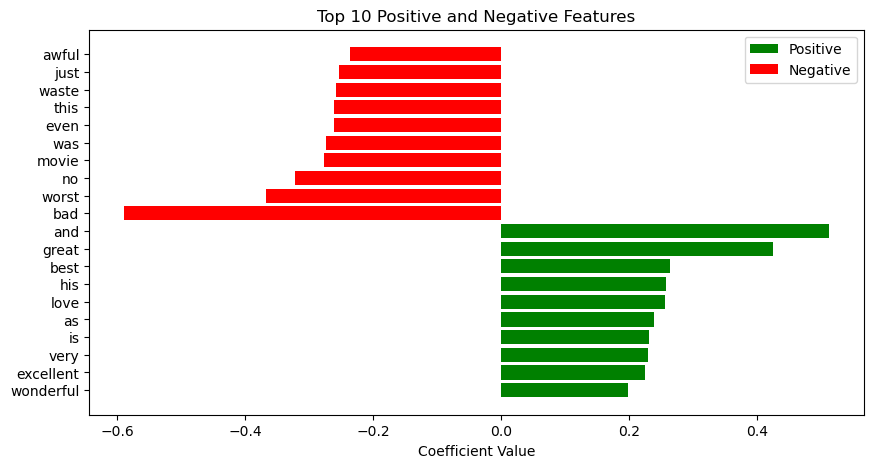

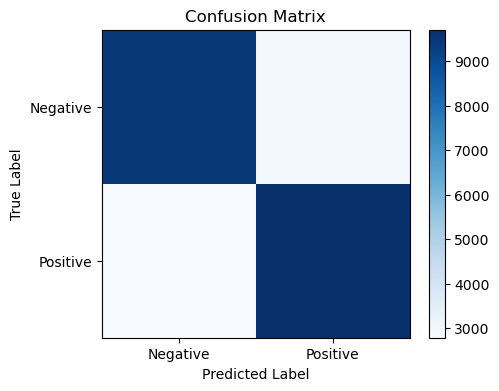

In [208]:
if __name__ == '__main__':
    main()